In [1]:
import dask.dataframe as dd
import dill
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import seaborn as sns
import time

from dask.distributed import Client, LocalCluster
from datetime import datetime, timedelta
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import SelectFromModel
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve, roc_curve, auc, f1_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
PATH_TRAIN = 'data_train.csv'
PATH_TEST = 'data_test.csv'
PATH_FEATURES = 'D:/Downloads/features.csv'

RANDOM_STATE = 7

In [4]:
def optimizing_dd(df, silent=False):    
    assert isinstance(df, dd.DataFrame), 'This is not a dask dataframe'
    start_t = time.time()
    
    if not silent:
        start_memory_usage = client.compute(df.memory_usage(deep=True).sum() / 1024**2)
        print('Start of dataframe memory optimization'.center(100,'*'))
        print(f'Memory usage by dataframe: {start_memory_usage.result():.02f} MB')
    
    df_dtype = pd.DataFrame(df.dtypes, columns=['dtype'], index = df.columns)
    
    df_min = client.compute(df.select_dtypes(['int', 'float']).min())
    df_max = client.compute(df.select_dtypes(['int', 'float']).max())
    df_is_int = client.compute(~(df.select_dtypes(['int', 'float']).fillna(0).astype(int).sum() - df.select_dtypes(['int', 'float']).fillna(0).sum()).astype('bool_'))
    
    df_dtype['min'] = df_min.result()
    df_dtype['max'] = df_max.result()
    df_dtype['is_int'] = df_is_int.result()
    
    df_dtype.loc[(df_dtype['is_int'] == True),'dtype'] = 'int64'
    df_dtype.loc[(df_dtype['is_int'] == True) & 
                 (df_dtype['min'] >= np.iinfo('int32').min) & 
                 (df_dtype['max'] <= np.iinfo('int32').max),'dtype'] = 'int32'
    df_dtype.loc[(df_dtype['is_int'] == True) & 
                 (df_dtype['min'] >= np.iinfo('int16').min) & 
                 (df_dtype['max'] <= np.iinfo('int16').max),'dtype'] = 'int16'
    df_dtype.loc[(df_dtype['is_int'] == True) & 
                 (df_dtype['min'] >= np.iinfo('int8').min) & 
                 (df_dtype['max'] <= np.iinfo('int8').max),'dtype'] = 'int8'
    
    df_dtype.loc[(df_dtype['is_int'] == True) & 
                 (df_dtype['min'] >= np.iinfo('uint64').min) ,'dtype'] = 'uint64'
    df_dtype.loc[(df_dtype['is_int'] == True) & 
                 (df_dtype['min'] >= np.iinfo('uint32').min) & 
                 (df_dtype['max'] <= np.iinfo('uint32').max),'dtype'] = 'uint32'
    df_dtype.loc[(df_dtype['is_int'] == True) & 
                 (df_dtype['min'] >= np.iinfo('uint16').min) & 
                 (df_dtype['max'] <= np.iinfo('uint16').max),'dtype'] = 'uint16'
    df_dtype.loc[(df_dtype['is_int'] == True) & 
                 (df_dtype['min'] >= np.iinfo('uint8').min) & 
                 (df_dtype['max'] <= np.iinfo('uint8').max),'dtype'] = 'uint8'
    
    df_dtype.loc[(df_dtype['is_int'] == True) & 
                 (df_dtype['min'] == 0) & 
                 (df_dtype['max'] == 1),'dtype'] = 'bool_'
    
    df_dtype.loc[(df_dtype['is_int'] == False), 'dtype'] = 'float64'
    df_dtype.loc[(df_dtype['is_int'] == False) & 
                 (df_dtype['min'] >= np.finfo('float32').min) & 
                 (df_dtype['max'] <= np.finfo('float32').max), 'dtype'] = 'float32'
    df_dtype.loc[(df_dtype['is_int'] == False) & 
                 (df_dtype['min'] >= np.finfo('float16').min) & 
                 (df_dtype['max'] <= np.finfo('float16').max), 'dtype'] = 'float16'
    
    for col in df.select_dtypes('object').columns:
        num_unique_values = client.compute(df[col].nunique())
        num_total_values = client.compute(df['id'].shape)
        if num_unique_values.result() / num_total_values[0].result() < 0.5:
            df_dtype.loc[col, 'dtype'] = 'category'
    
    dtypes = df_dtype['dtype'].to_dict()
    
    df = df.astype(dtypes)
    
    if not silent:
        memory_usage = client.compute(df.memory_usage(deep=True).sum() / 1024**2)
        print('MEMORY USAGE AFTER COMPLETION:'.center(40,'_'))
        print(f'Memory usage of properties dataframe is : {memory_usage.result():.02f} MB')
        print(f'This is {100*memory_usage.result()/start_memory_usage.result():.02f} % of the initial size')
        print(f'End of dataframe memory optimization, run time: {time_format(time.time()-start_t)}'.center(100,'*'))
    return df

In [5]:
def time_format(sec):
    return str(timedelta(seconds=sec))

### Load data

In [6]:
%%time

df_train = pd.read_csv(PATH_TRAIN, index_col=[1]).drop('Unnamed: 0', axis=1)
df_test = pd.read_csv(PATH_TEST, index_col=[1]).drop('Unnamed: 0', axis=1)

df_train.head(), df_test.head()

CPU times: total: 484 ms
Wall time: 472 ms


(         vas_id    buy_time  target
 id                                 
 540968      8.0  1537131600     0.0
 1454121     4.0  1531688400     0.0
 2458816     1.0  1534107600     0.0
 3535012     5.0  1535922000     0.0
 1693214     1.0  1535922000     0.0,
          vas_id    buy_time
 id                         
 3130519     2.0  1548018000
 2000860     4.0  1548018000
 1099444     2.0  1546808400
 1343255     5.0  1547413200
 1277040     2.0  1546808400)

In [7]:
%%time

if not os.path.exists('features.pkl'):
    cluster = LocalCluster(n_workers=2)
    client = Client(cluster)
    
    features = dd.read_csv(PATH_FEATURES, sep='\t').drop('Unnamed: 0', axis=1)
    features = optimizing_dd(features)
    features = features.set_index('id')
    features = features.compute()
    features.to_pickle('features.pkl')
else:
    features = pd.read_pickle('features.pkl')

CPU times: total: 2.67 s
Wall time: 7.31 s


In [8]:
features.head(10)

,buy_time,0,1,2,3,4,5,6,7,8,...,243,244,245,246,247,248,249,250,251,252
id,,,,,,,,,,,,,,,,,,,,,
0,1539550800,-87.479973,-258.499115,-93.790787,-192.486801,-99.208244,-213.591797,-16.086180,-65.076096,-6.783660,...,-977.373840,-613.770813,-25.996269,-37.625000,-306.747711,-25.832888,-0.694336,-12.175933,-0.456055,0
1,1546808400,-95.299973,-47.949112,-55.070786,-42.146797,-60.488247,-63.251789,-16.086180,-65.076096,-6.783660,...,-952.373840,-611.770813,-25.996269,-17.625000,-250.747726,-17.832888,-0.694336,-12.175933,-0.456055,0
2,1545598800,-96.799973,229.530884,-110.740784,305.723206,-116.158249,284.618225,-16.086180,-65.076096,-6.783660,...,2300.626221,1492.229248,-21.996269,-35.625000,368.252289,11.167111,7.304688,-12.175933,-0.456055,0
3,1544994000,-25.609970,-275.969116,-27.690786,-287.056793,-33.108246,-308.161804,-16.086180,-65.076096,-6.783660,...,971.626160,-613.770813,-25.996269,-37.625000,-229.747726,-19.832888,-0.694336,-12.175933,-0.456055,0
4,1538341200,-96.799973,-323.429108,-110.740784,-376.036804,-116.158249,-397.141785,-16.086180,19.673903,-6.783660,...,4806.625977,4140.229004,-25.996269,-37.625000,-35.747723,-20.832888,-0.694336,-7.175933,-0.456055,0
5,1548018000,-96.799973,-407.009125,-110.740784,-459.616791,-116.158249,-480.721802,-16.086180,-65.076096,-6.783660,...,-977.373840,-613.770813,-25.996269,-37.625000,-306.747711,-25.832888,-0.694336,-12.175933,-0.456055,0
6,1548018000,-96.799973,-407.009125,-110.740784,-459.616791,-116.158249,-480.721802,-16.086180,-65.076096,-6.783660,...,-977.373840,-613.770813,-25.996269,-37.625000,-306.747711,-25.832888,-0.694336,-12.175933,-0.456055,0
7,1544994000,-96.799973,-94.619110,-110.740784,-147.226791,-116.158249,-160.691788,-16.086180,-65.076096,-6.783660,...,-944.373840,-613.770813,-25.996269,-37.625000,-276.747711,-23.832888,-0.694336,-11.175933,-0.456055,1
8,1547413200,-27.139971,-207.729111,-10.930786,-165.866791,-16.348246,-186.971786,-16.086180,-65.076096,-6.783660,...,-977.373840,-613.770813,-25.996269,-9.632812,-216.747726,-25.832888,-0.694336,-12.175933,-0.456055,0


### Merge data from features dataframe to train/test

In [9]:
test_train = pd.merge(df_test, df_train, left_index=True, right_index=True)

In [10]:
test_train

,vas_id_x,buy_time_x,vas_id_y,buy_time_y,target
id,,,,,
64,4.0,1548018000,5.0,1546203600,0.0
471,6.0,1547413200,5.0,1533502800,0.0
1200,6.0,1546808400,4.0,1540155600,0.0
1352,2.0,1546808400,6.0,1544994000,1.0
1446,6.0,1546808400,4.0,1546203600,1.0
...,...,...,...,...,...
4187202,6.0,1546808400,2.0,1534712400,0.0
4213528,2.0,1547413200,1.0,1542574800,1.0
4223998,2.0,1546808400,6.0,1545598800,1.0


In [11]:
print(f'Missing values in test-train data: \
      {test_train.isnull().sum().sum() / df_train.count().sum() * 100:.02f} % of total Values')

Missing values in test-train data:       0.00 % of total Values


In [12]:
train_feature = pd.merge(df_train, features, left_index=True, right_index=True)

In [13]:
train_feature

,vas_id,buy_time_x,target,buy_time_y,0,1,2,3,4,5,...,243,244,245,246,247,248,249,250,251,252
id,,,,,,,,,,,,,,,,,,,,,
2,2.0,1545598800,0.0,1545598800,-96.799973,229.530884,-110.740784,305.723206,-116.158249,284.618225,...,2300.626221,1492.229248,-21.996269,-35.625,368.252289,11.167111,7.304688,-12.175933,-0.456055,0
4,1.0,1533502800,0.0,1538341200,-96.799973,-323.429108,-110.740784,-376.036804,-116.158249,-397.141785,...,4806.625977,4140.229004,-25.996269,-37.625,-35.747723,-20.832888,-0.694336,-7.175933,-0.456055,0
15,1.0,1534107600,0.0,1531688400,260.810028,186.710892,249.409210,140.873199,243.991760,119.768211,...,-381.373840,-613.770813,-24.996269,-31.625,-212.747726,108.167114,-0.694336,107.824066,13.546875,1
16,2.0,1540760400,0.0,1548018000,152.050034,257.220886,195.609207,267.113190,190.191757,246.008209,...,3185.626221,-613.770813,-21.996269,-37.625,-139.747726,-24.832888,-0.694336,-12.175933,-0.456055,0
29,1.0,1533502800,0.0,1532898000,-52.309971,-230.219116,-36.590786,-248.926804,-42.008247,-270.031799,...,-847.373840,-509.770782,-25.996269,-37.625,-233.747726,-10.832889,-0.694336,2.824067,-0.456055,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4362634,1.0,1546203600,0.0,1544994000,-96.799973,-77.679115,-110.740784,-130.286804,-116.158249,-151.391785,...,-26.373846,-613.770813,118.003731,98.375,-219.747726,151.167114,-0.694336,-12.175933,-0.456055,0
4362640,2.0,1546203600,0.0,1546203600,-93.749969,-66.149109,-105.190788,-107.776794,-110.608246,-128.881790,...,-974.373840,-610.770813,-25.996269,-37.625,-306.747711,-25.832888,-0.694336,-12.175933,-0.456055,1
4362647,6.0,1546203600,0.0,1537736400,288.800018,-9.859112,363.839203,284.973206,358.421753,263.868225,...,1351.626099,745.229187,-25.996269,-28.625,26.252275,34.167110,-0.694336,47.824066,-0.456055,0


In [14]:
y = train_feature['target']
X = train_feature.drop(['target'], axis=1)

In [15]:
y

id
2          0.0
4          0.0
15         0.0
16         0.0
29         0.0
          ... 
4362634    0.0
4362640    0.0
4362647    0.0
4362684    0.0
4362694    0.0
Name: target, Length: 860052, dtype: float64

In [16]:
X

,vas_id,buy_time_x,buy_time_y,0,1,2,3,4,5,6,...,243,244,245,246,247,248,249,250,251,252
id,,,,,,,,,,,,,,,,,,,,,
2,2.0,1545598800,1545598800,-96.799973,229.530884,-110.740784,305.723206,-116.158249,284.618225,-16.086180,...,2300.626221,1492.229248,-21.996269,-35.625,368.252289,11.167111,7.304688,-12.175933,-0.456055,0
4,1.0,1533502800,1538341200,-96.799973,-323.429108,-110.740784,-376.036804,-116.158249,-397.141785,-16.086180,...,4806.625977,4140.229004,-25.996269,-37.625,-35.747723,-20.832888,-0.694336,-7.175933,-0.456055,0
15,1.0,1534107600,1531688400,260.810028,186.710892,249.409210,140.873199,243.991760,119.768211,341.523834,...,-381.373840,-613.770813,-24.996269,-31.625,-212.747726,108.167114,-0.694336,107.824066,13.546875,1
16,2.0,1540760400,1548018000,152.050034,257.220886,195.609207,267.113190,190.191757,246.008209,-16.086180,...,3185.626221,-613.770813,-21.996269,-37.625,-139.747726,-24.832888,-0.694336,-12.175933,-0.456055,0
29,1.0,1533502800,1532898000,-52.309971,-230.219116,-36.590786,-248.926804,-42.008247,-270.031799,-16.086180,...,-847.373840,-509.770782,-25.996269,-37.625,-233.747726,-10.832889,-0.694336,2.824067,-0.456055,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4362634,1.0,1546203600,1544994000,-96.799973,-77.679115,-110.740784,-130.286804,-116.158249,-151.391785,-16.086180,...,-26.373846,-613.770813,118.003731,98.375,-219.747726,151.167114,-0.694336,-12.175933,-0.456055,0
4362640,2.0,1546203600,1546203600,-93.749969,-66.149109,-105.190788,-107.776794,-110.608246,-128.881790,-16.086180,...,-974.373840,-610.770813,-25.996269,-37.625,-306.747711,-25.832888,-0.694336,-12.175933,-0.456055,1
4362647,6.0,1546203600,1537736400,288.800018,-9.859112,363.839203,284.973206,358.421753,263.868225,-16.086180,...,1351.626099,745.229187,-25.996269,-28.625,26.252275,34.167110,-0.694336,47.824066,-0.456055,0


In [17]:
test_feature = pd.merge(df_test, features, left_index=True, right_index=True)

In [18]:
test_feature['id']=test_feature.index

In [19]:
test_feature

,vas_id,buy_time_x,buy_time_y,0,1,2,3,4,5,6,...,244,245,246,247,248,249,250,251,252,id
id,,,,,,,,,,,,,,,,,,,,,
55,2.0,1547413200,1533502800,-42.559971,99.460884,-43.780785,72.293205,-49.198246,51.188210,31.373819,...,-570.770813,-24.996269,-36.625000,-212.747726,-14.832889,-0.694336,-1.175933,-0.456055,1,55
64,4.0,1548018000,1532293200,71.840027,1048.560913,117.219215,1161.203247,111.801750,1140.098267,119.503822,...,-220.770798,761.003723,-37.625000,3790.252197,-5.832889,-0.694336,7.824067,-0.456055,0,64
151,2.0,1547413200,1545598800,-90.439972,77.750885,-104.380783,240.403198,-109.798248,227.778214,-16.086180,...,-613.770813,-25.996269,-6.628906,-14.747724,-24.832888,0.305664,-12.175933,-0.456055,1,151
274,2.0,1547413200,1540760400,-25.609970,-123.419113,-39.550785,-176.026794,-44.968246,-186.961792,-16.086180,...,-108.770790,-25.996269,-37.625000,-230.747726,-0.832889,-0.694336,-12.175933,-0.456055,0,274
274,4.0,1548018000,1540760400,-25.609970,-123.419113,-39.550785,-176.026794,-44.968246,-186.961792,-16.086180,...,-108.770790,-25.996269,-37.625000,-230.747726,-0.832889,-0.694336,-12.175933,-0.456055,0,274
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4362676,2.0,1548018000,1535922000,-92.559967,4.970888,-106.500786,-47.636799,-111.918243,-68.741791,-16.086180,...,-613.770813,-25.996269,-37.625000,-304.747711,-25.832888,-0.694336,-12.175933,-0.456055,0,4362676
4362677,2.0,1547413200,1531688400,-47.219971,218.950882,-52.260784,224.393204,-57.678246,203.288208,31.373819,...,3038.229248,-25.996269,-26.625000,-104.747726,-9.832889,-0.694336,1.824067,1.543945,0,4362677
4362697,5.0,1546808400,1546203600,-90.699974,-262.139099,-104.640785,-261.796783,-110.058243,-282.901794,-16.086180,...,-611.770813,-21.996269,-37.625000,-63.747723,31.167112,-0.694336,-12.175933,-0.456055,1,4362697


### Split dataset

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    random_state=RANDOM_STATE, shuffle=True, stratify=y)

In [21]:
del X, y

### Data Analysis

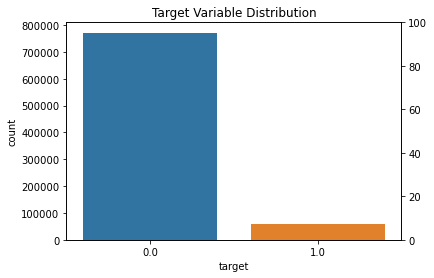

In [22]:
plt.title('Target Variable Distribution')
sns.countplot(x='target', data=df_train).twinx().set_ylim(0,100);

In [23]:
print(f'Missing values in train data: \
      {df_train.isnull().sum().sum() / df_train.count().sum() * 100:.02f} % of total Values')

Missing values in train data:       0.00 % of total Values


In [24]:
print(f'Missing values in features data: \
      {features.isnull().sum().sum() / features.count().sum() * 100:.02f} % of total Values')

Missing values in features data:       0.00 % of total Values


### Pipeline construction

In [25]:
def get_features(X: pd.DataFrame):
    assert isinstance(X, pd.DataFrame)
    
    X_nunique = X.apply(lambda x: x.nunique(dropna=False))
    
    f_all = set(X_nunique.index.tolist())
    f_date = set(col for col in X.columns if 'time' in col)
    f_other = f_all - f_date
    f_const = set(X_nunique[X_nunique == 1].index.tolist())
    f_other = f_other - f_const
    f_numeric = (X.fillna(0).astype(int).sum() - X.fillna(0).sum()).abs()
    f_numeric = set(f_numeric[f_numeric > 0].index.tolist())
    f_other = f_other - f_numeric
    f_binary = set(X.loc[:, f_other].columns[((X.loc[:, f_other].max() == 1) & 
                                               (X.loc[:, f_other].min() == 0) & 
                                               (X.loc[:, f_other].isnull().sum() == 0))])
    f_other = f_other - f_binary
    f_categorical = set(X_nunique.loc[f_other][X_nunique.loc[f_other] <= 10].index.tolist())
    f_other = f_other - f_categorical
    f_numeric = f_numeric | f_other
    f_other = f_other - f_numeric
    
    assert(X_nunique.shape[0] == len(f_date) + 
           len(f_const) + 
           len(f_binary) + 
           len(f_numeric) + 
           len(f_categorical))
    
    print(f'f_all: {X.shape[1]}\n')
    print(f'f_date: {len(f_date)}')
    print(f'f_const: {len(f_const)}')
    print(f'f_binary: {len(f_binary)}')
    print(f'f_categorical: {len(f_categorical)}')
    print(f'f_numeric: {len(f_numeric)}')

    f_all = list(f_all)

    f_date = list(f_date)
    f_binary = list(f_binary)
    f_categorical = list(f_categorical)
    f_numeric = list(f_numeric)

    return  list(f_all), list(f_date), list(f_binary), list(f_categorical), list(f_numeric)

In [26]:
f_all, f_date, f_binary, f_categorical, f_numeric = get_features(X_train)

f_all: 256

f_date: 2
f_const: 5
f_binary: 0
f_categorical: 1
f_numeric: 248


In [27]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self
      
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)

        try:
            return X[self.columns]
        except KeyError:
            cols_error = list(set(self.columns) - set(X.columns))
            raise KeyError(f'DataFrame does not contain the following columns: {cols_error}')

In [28]:
class GetDate(BaseEstimator, TransformerMixin):
    def __init__(self, silent=True):
        self.silent = silent
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if not self.silent:
            start_t = time.time()
            print('Start geting date from timestamp'.center(100,'*'))
        if isinstance(X, pd.Series):
            X = pd.DataFrame(X)

        assert isinstance(X, pd.DataFrame), 'This is not a pandas dataframe or series'
        
        df = pd.DataFrame()
        
        for col in X.columns:
            df[f'{col}_day'] = pd.to_datetime(X[col], unit='s').dt.day
            df[f'{col}_month'] = pd.to_datetime(X[col], unit='s').dt.month
            df[f'{col}_week'] = pd.to_datetime(X[col], unit='s').dt.week
            
        if not self.silent:
            print(f'End geting date from timestamp, run time: {time_format(time.time()-start_t)}'.center(100,'*'))
            print()
        return df

In [29]:
feature_union_pipeline = FeatureUnion(transformer_list=[
                        ('date_features', make_pipeline(
                            ColumnSelector(f_date),
                            GetDate(),
                            StandardScaler()
                        )),
                        ('numeric_features', make_pipeline(
                            ColumnSelector(f_numeric),
                            SimpleImputer(strategy='constant', fill_value=0),
                            StandardScaler(),
                        )),
                        ('categorical_features', make_pipeline(
                            ColumnSelector(f_categorical),
                            SimpleImputer(strategy='most_frequent'),
                            OneHotEncoder(handle_unknown='ignore', sparse=False)
                        )),
                        ('boolean_features', make_pipeline(
                            ColumnSelector(f_binary),
                        ))
])

In [30]:
feature_prep_pipeline = make_pipeline(
    ColumnSelector(columns=f_all),
    # AddFeatures(features),
    feature_union_pipeline
)

In [31]:
n_features = feature_prep_pipeline.fit_transform(X_test).shape
n_features

(258016, 262)

### Compare different models

In [32]:
models_list = {
    'Logistic Regression': LogisticRegression(random_state=RANDOM_STATE, n_jobs=-1),
    'Random Forest Classifier': RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1),
    'XGBoost': XGBClassifier(random_state=RANDOM_STATE, n_jobs=-1),
    'LightGBM': LGBMClassifier(random_state=RANDOM_STATE),
    'CatBoost': CatBoostClassifier(random_state=RANDOM_STATE, logging_level='Silent'),
}

In [33]:
for model_name, model in models_list.items():
    start_t = time.time()
    print(f'Start fit {model_name}')
    model.fit(X_train, y_train)
    print(f'End fit {model_name}, spent time: {time_format(time.time()-start_t)}\n')

Start fit Logistic Regression
End fit Logistic Regression, spent time: 0:04:26.323226

Start fit Random Forest Classifier
End fit Random Forest Classifier, spent time: 0:07:42.235523

Start fit XGBoost
End fit XGBoost, spent time: 0:02:44.059343

Start fit LightGBM
End fit LightGBM, spent time: 0:00:14.389823

Start fit CatBoost
End fit CatBoost, spent time: 0:03:27.053951



In [34]:
def get_classification_report(models_list, X_train, y_train, X_test, y_test, classes, title='', threshold=0.5):
    for model_name, model in models_list.items():
        y_train_pred = model.predict_proba(X_train)[:,1]
        y_test_pred = model.predict_proba(X_test)[:,1]
        y_train_pred = y_train_pred > threshold
        y_test_pred = y_test_pred > threshold
        
        print(f'{model_name}. {title}')
        print('TRAIN\n' + classification_report(y_train, y_train_pred))
        print('TEST\n' + classification_report(y_test, y_test_pred))
        fig, ax = plt.subplots(figsize=(8, 6))
        ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, labels=model.classes_, ax=ax, colorbar=False)
        plt.show()

def plot_roc_pr(models_list, X_train, y_train, X_test, y_test, title='', threshold=0.5):

    f, (ax1, ax2) = plt.subplots(2, 1, sharey=True)
    
    f.set_figheight(10)
    f.set_figwidth(20)
    
    ax1 = plt.subplot(121)
    ax1.set_title(f'ROC. {title}')
    ax1.set_xlabel('TPR')
    ax1.set_ylabel('FPR')
    ax1.set_aspect('equal')
    ax1.plot([0, 1], [0, 1], 'k--')
    
    ax2 = plt.subplot(122)
    ax2.set_title(f'PR. {title}')
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_aspect('equal')
    
    f_scores = np.linspace(0.2, 0.8, num=4)
    for f_score in f_scores:
        x = np.linspace(0.01, 1)
        y = f_score * x / (2 * x - f_score)
        l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
        ax2.annotate(f'f1={f_score:0.1f}', xy=(0.9, y[45] + 0.02), fontsize=14)
        
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    
    for model_name, model in models_list.items():
        y_pred_proba = model.predict_proba(X_test)[:,1]
        y_pred = y_pred_proba > threshold
        
        fpr, tpr, roc_thresholds = roc_curve(y_test, y_pred_proba)
        precision, recall, pr_thresholds = precision_recall_curve(y_test, y_pred_proba)
        
        ax1.plot(fpr, tpr, label=f'{model_name} (AUC={auc(fpr, tpr):.2f})')       
        ax2.plot(recall, precision, label=f'{model_name} (f1={f1_score(y_test, y_pred):.2f})')

    ax1.legend(loc="lower right")
    ax2.legend(loc="lower left")
    
    plt.show()

Logistic Regression. Baseline
TRAIN
              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96    558491
         1.0       0.00      0.00      0.00     43545

    accuracy                           0.93    602036
   macro avg       0.46      0.50      0.48    602036
weighted avg       0.86      0.93      0.89    602036

TEST
              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96    239354
         1.0       0.00      0.00      0.00     18662

    accuracy                           0.93    258016
   macro avg       0.46      0.50      0.48    258016
weighted avg       0.86      0.93      0.89    258016



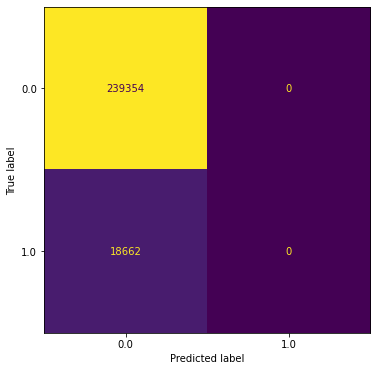

Random Forest Classifier. Baseline
TRAIN
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    558491
         1.0       1.00      1.00      1.00     43545

    accuracy                           1.00    602036
   macro avg       1.00      1.00      1.00    602036
weighted avg       1.00      1.00      1.00    602036

TEST
              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96    239354
         1.0       0.58      0.09      0.15     18662

    accuracy                           0.93    258016
   macro avg       0.76      0.54      0.56    258016
weighted avg       0.91      0.93      0.90    258016



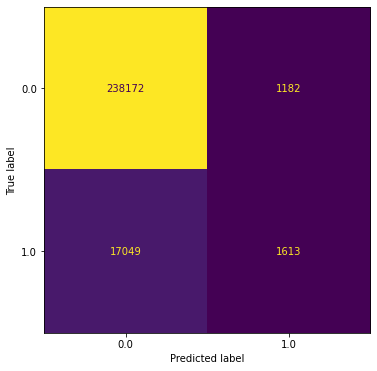

XGBoost. Baseline
TRAIN
              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97    558491
         1.0       0.76      0.35      0.48     43545

    accuracy                           0.95    602036
   macro avg       0.86      0.67      0.73    602036
weighted avg       0.94      0.95      0.94    602036

TEST
              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97    239354
         1.0       0.63      0.28      0.39     18662

    accuracy                           0.94    258016
   macro avg       0.79      0.64      0.68    258016
weighted avg       0.92      0.94      0.92    258016



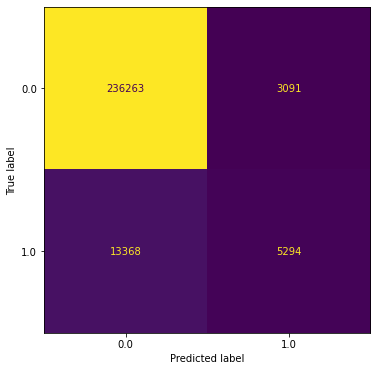

LightGBM. Baseline
TRAIN
              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97    558491
         1.0       0.73      0.26      0.38     43545

    accuracy                           0.94    602036
   macro avg       0.84      0.63      0.68    602036
weighted avg       0.93      0.94      0.93    602036

TEST
              precision    recall  f1-score   support

         0.0       0.94      0.99      0.97    239354
         1.0       0.69      0.25      0.36     18662

    accuracy                           0.94    258016
   macro avg       0.82      0.62      0.67    258016
weighted avg       0.93      0.94      0.92    258016



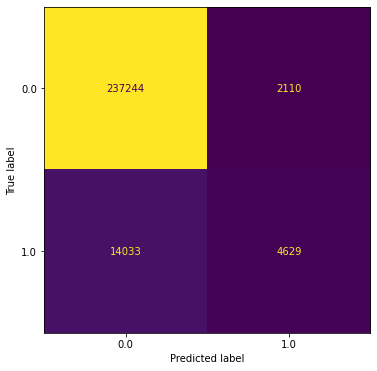

CatBoost. Baseline
TRAIN
              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97    558491
         1.0       0.78      0.40      0.53     43545

    accuracy                           0.95    602036
   macro avg       0.87      0.70      0.75    602036
weighted avg       0.94      0.95      0.94    602036

TEST
              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97    239354
         1.0       0.63      0.30      0.41     18662

    accuracy                           0.94    258016
   macro avg       0.79      0.64      0.69    258016
weighted avg       0.92      0.94      0.93    258016



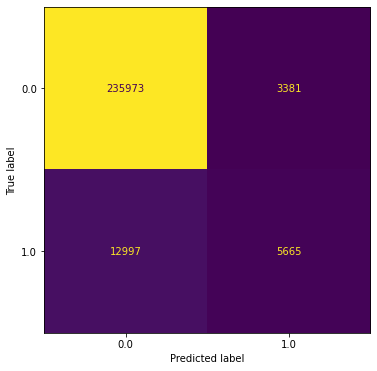

In [35]:
get_classification_report(models_list, X_train, y_train, X_test, y_test, classes=['False', 'True'], title='Baseline')

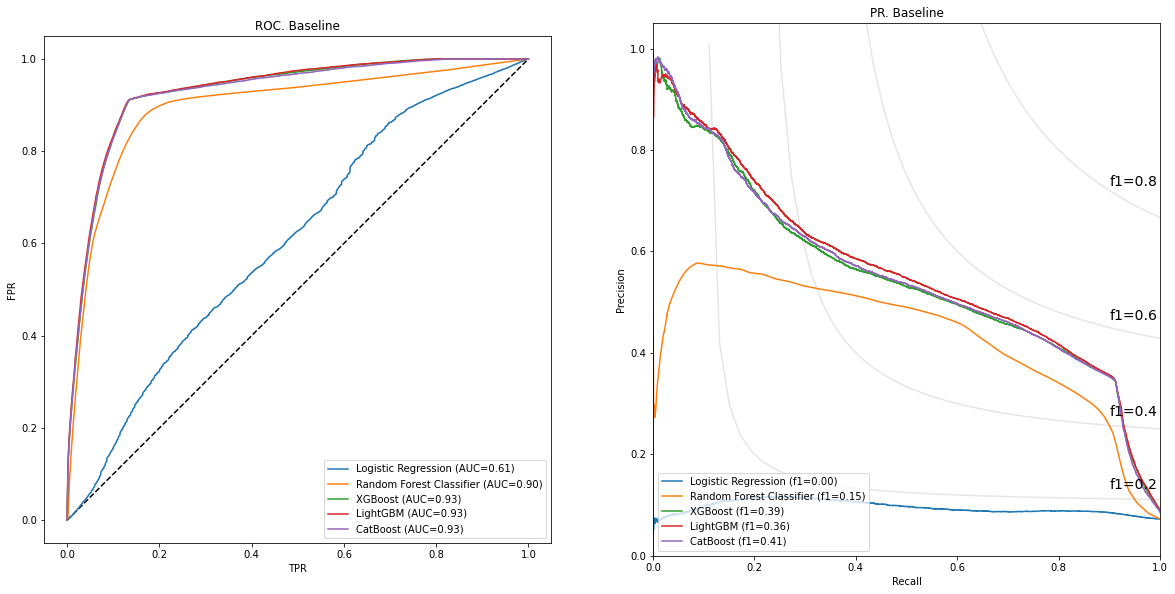

In [36]:
plot_roc_pr(models_list, X_train, y_train, X_test, y_test, title='Baseline')

### Final model

In [37]:
y = train_feature['target']
X = train_feature.drop(['target'], axis=1)

In [38]:
%%time

best_model = make_pipeline(
    feature_prep_pipeline,
    CatBoostClassifier(random_state=RANDOM_STATE, logging_level='Silent')
)

best_model.fit(X, y)

CPU times: total: 33min 23s
Wall time: 5min 23s


Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columnselector',
                                  ColumnSelector(columns=['29', '18', '70',
                                                          '166', '140', '131',
                                                          '57', '77', '95',
                                                          '152', '156', '39',
                                                          '143', '222', '196',
                                                          '251', '199', '45',
                                                          '104', '189', '213',
                                                          '210', '0', '90',
                                                          '129', '178', '158',
                                                          '4', '215', '101', ...])),
                                 ('featureunion',
                                  FeatureUnion(transformer_list=[('date_features',
 

TRAIN
              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97    797845
         1.0       0.73      0.37      0.49     62207

    accuracy                           0.94    860052
   macro avg       0.84      0.68      0.73    860052
weighted avg       0.94      0.94      0.94    860052



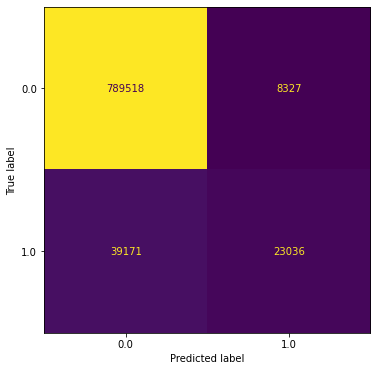

In [45]:
y_train_pred = model.predict_proba(X)[:,1]
y_train_pred = y_train_pred > 0.5
print('TRAIN\n' + classification_report(y, y_train_pred))
fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay.from_predictions(y, y_train_pred, labels=model.classes_, ax=ax, colorbar=False)
plt.show()

In [39]:
test_feature['target'] = best_model.predict_proba(test_feature)[:,1]

In [40]:
answers_test = test_feature.drop(columns=test_feature.iloc[:, 2:-1])
answers_test = answers_test.rename(columns={'buy_time_x': 'buy_time'})

In [41]:
answers_test

,vas_id,buy_time,target
id,,,
55,2.0,1547413200,0.015131
64,4.0,1548018000,0.060648
151,2.0,1547413200,0.012131
274,2.0,1547413200,0.009693
274,4.0,1548018000,0.134804
...,...,...,...
4362676,2.0,1548018000,0.008840
4362677,2.0,1547413200,0.012619
4362697,5.0,1546808400,0.011828


### Result

In [42]:
with open("model.pkl", "wb") as f:
    pickle.dump(best_model, f)

In [43]:
compression_opts = dict(method='zip', archive_name='answers_test.csv')  
answers_test.to_csv('answers_test.zip', index=False, compression=compression_opts) 